In [1]:
# process_and_merge_parquets.py
import os
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.mixture import GaussianMixture
from scipy.stats import median_abs_deviation

# ========== USER CONFIG ==========
DATA_DIR = r"C:\\Users\\Professional\\Documents\\VirusNeutr\\parquet"
OUT_DIR = os.path.join(DATA_DIR, "processed")   # per-file outputs (optional)
MERGED_OUT = os.path.join(DATA_DIR, "merged_processed.parquet")
SAVE_PER_FILE = True    # если True — сохраняет обработанные отдельные файлы в OUT_DIR
MIN_EVENTS_FOR_GMM = 50
LOG_SHIFT = 1e-6        # shift for log10 to avoid log(0)
ASINH_COFACTOR = 0.1    # cofactor for asinh on normalized data (0..1). Подкорректируй при желании.
EPS = 1e-9
# ==================================

os.makedirs(OUT_DIR, exist_ok=True)

def drop_nonfinite_rows(df):
    num_cols = df.select_dtypes(include=[np.number]).columns
    if len(num_cols) == 0:
        return df.copy(), 0
    mask = np.isfinite(df[num_cols].values).all(axis=1)
    removed = (~mask).sum()
    return df.loc[mask].copy(), int(removed)

def minmax_normalize_df(df, exclude_cols=('label',)):
    """
    Возвращает копию df, где все числовые колонки (кроме exclude_cols) нормализованы в [0,1].
    Также возвращает словарь params {col: (min, max)}.
    """
    df_out = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in exclude_cols and not str(c).startswith("__")]
    params = {}
    for col in num_cols:
        vals = pd.to_numeric(df[col], errors='coerce').astype(float)
        non_nan = vals.dropna()
        if non_nan.empty:
            df_out[col] = 0.0
            params[col] = (None, None)
            continue
        cmin = float(non_nan.min())
        cmax = float(non_nan.max())
        params[col] = (cmin, cmax)
        if np.isfinite(cmin) and np.isfinite(cmax) and (cmax > cmin):
            normed = (vals - cmin) / (cmax - cmin)
            normed = normed.clip(0.0, 1.0)
            df_out[col] = normed
        else:
            # constant column
            df_out[col] = 0.0
    return df_out, params

def detect_fitc_column(df):
    # prefer these names
    candidates = ['FITC-A', 'B530-A', 'FITC_raw', 'FITC', 'FITC-H']
    for c in candidates:
        if c in df.columns:
            return c
    # fallback: pick the numeric column name that contains 'fitc' (case-insensitive)
    for c in df.columns:
        if 'fitc' in str(c).lower():
            return c
    # finally, try 'FITC_raw'
    if 'FITC_raw' in df.columns:
        return 'FITC_raw'
    return None

def compute_derived_columns(df):
    """
    На вход — DataFrame, где числовые колонки уже нормализованы в [0,1] (кроме label).
    Добавляет/пересчитывает:
      - FITC_raw (берётся из FITC-A или детектированного столбца)
      - FITC_log10 = log10(FITC_raw + LOG_SHIFT)
      - FITC_asinh = asinh(FITC_raw / ASINH_COFACTOR)
      - FITC_pct = percentile rank внутри sample (по FITC_log10)
      - FITC_z_robust = (FITC_log10 - median) / MAD
      - FSC_ratio = FSC-A / (FSC-H + eps)
      - SSC_ratio = SSC-A / (SSC-H + eps)
      - gmm_prob_infected = вероятность правой компоненты GMM(2) по FITC_log10
    """
    df = df.copy()
    # detect FITC column
    fitc_col = detect_fitc_column(df) or 'FITC_raw'
    # ensure FITC_raw column exists (if not — copy from fitc_col)
    if fitc_col not in df.columns:
        df['FITC_raw'] = np.nan
    else:
        df['FITC_raw'] = pd.to_numeric(df[fitc_col], errors='coerce').astype(float)

    # LOG (on normalized values)
    with np.errstate(divide='ignore', invalid='ignore'):
        df['FITC_log10'] = np.log10(df['FITC_raw'].fillna(0.0) + float(LOG_SHIFT))

    # asinh
    df['FITC_asinh'] = np.arcsinh(df['FITC_raw'].fillna(0.0) / float(ASINH_COFACTOR))

    # FITC_pct: percentile rank in sample (here df is one sample)
    try:
        df['FITC_pct'] = df['FITC_log10'].rank(pct=True, na_option='bottom')
    except Exception:
        # fallback: use raw ranks
        df['FITC_pct'] = df['FITC_log10'].rank(pct=True, na_option='bottom') if 'FITC_log10' in df else np.nan

    # FITC_z_robust
    arr = df['FITC_log10'].values
    med = np.nanmedian(arr)
    mad = median_abs_deviation(arr, nan_policy='omit')
    if mad is None or mad == 0:
        mad = EPS
    df['FITC_z_robust'] = (df['FITC_log10'] - med) / (mad + EPS)

    # ratios
    if 'FSC-A' in df.columns and 'FSC-H' in df.columns:
        df['FSC_ratio'] = pd.to_numeric(df['FSC-A'], errors='coerce') / (pd.to_numeric(df['FSC-H'], errors='coerce') + EPS)
    else:
        df['FSC_ratio'] = np.nan
    if 'SSC-A' in df.columns and 'SSC-H' in df.columns:
        df['SSC_ratio'] = pd.to_numeric(df['SSC-A'], errors='coerce') / (pd.to_numeric(df['SSC-H'], errors='coerce') + EPS)
    else:
        df['SSC_ratio'] = np.nan

    # gmm_prob_infected on FITC_log10
    # prepare X (2D) with finite values
    x = pd.to_numeric(df['FITC_log10'], errors='coerce').values.reshape(-1, 1)
    mask = np.isfinite(x).ravel()
    x_fit = x[mask]
    df['gmm_prob_infected'] = np.nan
    if x_fit.shape[0] >= MIN_EVENTS_FOR_GMM:
        try:
            gmm = GaussianMixture(n_components=2, random_state=0)
            gmm.fit(x_fit)
            probs = np.full((len(x), 2), np.nan)
            probs_mask = gmm.predict_proba(x_fit)
            probs[mask, :] = probs_mask
            means = gmm.means_.ravel()
            right_comp = int(np.argmax(means))
            df['gmm_prob_infected'] = probs[:, right_comp]
        except Exception:
            df['gmm_prob_infected'] = np.nan
    else:
        # too few events: set 0 or NaN — choose NaN to indicate unavailable
        df['gmm_prob_infected'] = np.nan

    return df

# ==========================
# MAIN processing loop
# ==========================
files = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
if len(files) == 0:
    raise SystemExit(f"No parquet files found in {DATA_DIR}")

writer = None
schema = None
rows_written = 0
total_removed = 0
total_inputs = 0
processed_files = 0

print(f"Processing {len(files)} files...")

for p in tqdm(files, desc="Files"):
    try:
        df = pd.read_parquet(p)
    except Exception as e:
        print(f"Warning: can't read {p}: {e}")
        continue

    total_inputs += len(df)
    # 1) drop rows with non-finite numeric values
    df_clean, removed = drop_nonfinite_rows(df)
    total_removed += removed
    if df_clean.empty:
        # nothing to write
        continue

    # 2) min-max normalize numeric cols (per file)
    df_norm, params = minmax_normalize_df(df_clean, exclude_cols=('label',))

    # 3) compute derived columns on normalized data
    df_proc = compute_derived_columns(df_norm)

    # optional: save per-file
    if SAVE_PER_FILE:
        out_name = os.path.basename(p).replace(".parquet", "_processed.parquet")
        out_path = os.path.join(OUT_DIR, out_name)
        try:
            df_proc.to_parquet(out_path, index=False)
        except Exception as e:
            print(f"Warning: couldn't save processed file {out_path}: {e}")

    # 4) append to merged parquet using pyarrow writer (set schema by first written file)
    # convert to pyarrow table
    try:
        table = pa.Table.from_pandas(df_proc, safe=False)
    except Exception as e:
        # if fails, try to downcast types / select numeric + label columns explicitly
        df_small = df_proc.copy()
        # ensure strings are not objects — cast problematic columns to strings
        for c in df_small.columns:
            if df_small[c].dtype == 'object':
                df_small[c] = df_small[c].astype(str)
        table = pa.Table.from_pandas(df_small, safe=False)

    if writer is None:
        schema = table.schema
        writer = pq.ParquetWriter(MERGED_OUT, schema, compression='snappy', use_dictionary=True)
    else:
        # reindex to schema if necessary (add missing cols)
        schema_cols = [f.name for f in schema]
        for c in schema_cols:
            if c not in df_proc.columns:
                df_proc[c] = np.nan
        df_proc = df_proc[schema_cols]
        table = pa.Table.from_pandas(df_proc, schema=schema, safe=False)

    writer.write_table(table)
    rows_written += table.num_rows
    processed_files += 1

# close writer
if writer is not None:
    writer.close()

print(f"Done. Files processed: {processed_files}/{len(files)}")
print(f"Rows input: {total_inputs}, rows removed (nonfinite): {total_removed}, rows written: {rows_written}")
print("Merged processed parquet saved to:", MERGED_OUT)
print("Per-file processed copies saved to:", OUT_DIR if SAVE_PER_FILE else "(not saved)")



Processing 1435 files...


Files: 100%|██████████| 1435/1435 [03:56<00:00,  6.06it/s]

Done. Files processed: 1435/1435
Rows input: 48487827, rows removed (nonfinite): 24544, rows written: 48463283
Merged processed parquet saved to: C:\\Users\\Professional\\Documents\\VirusNeutr\\parquet\merged_processed.parquet
Per-file processed copies saved to: C:\\Users\\Professional\\Documents\\VirusNeutr\\parquet\processed


In [2]:
df = pd.read_parquet("C:\\Users\\Professional\\Documents\\VirusNeutr\\parquet\\merged_processed.parquet")
df


,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected
0.0,0.052952,0.623713,0.086024,0.008641,0.515030,0.009820,False,0.009820,-2.007822,0.098048,0.627628,0.595366,0.163190,0.825748,0.996436
1.0,0.688091,1.000000,0.099226,0.573388,0.989684,0.010410,False,0.010410,-1.982525,0.103909,0.888889,5.193378,0.833302,0.989684,0.914950
2.0,0.471071,0.837872,0.105617,0.295011,0.784652,0.010085,False,0.010085,-1.996261,0.100684,0.813814,2.696776,0.626257,0.936482,0.992468
3.0,0.017603,0.532765,0.078204,0.001257,0.504533,0.009689,False,0.009689,-2.013658,0.096743,0.354354,-0.465317,0.071402,0.947008,0.996098
4.0,0.045924,0.438589,0.089136,0.004386,0.486525,0.009801,False,0.009801,-2.008667,0.097858,0.600601,0.441879,0.095504,1.109296,0.996459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.224035,0.016337,NaN,0.094823,0.025527,0.003873,False,0.003873,-2.411867,0.038718,0.458120,-0.141791,0.423250,1.562520,0.098564
NaN,0.313604,0.016386,NaN,0.142364,0.025911,0.038430,True,0.038430,-1.415313,0.375424,0.957305,5.660955,0.453963,1.581304,0.999998
NaN,0.200443,0.013140,NaN,0.087041,0.025016,0.003121,False,0.003121,-2.505568,0.031205,0.299639,-0.687391,0.434243,1.903751,0.096606
NaN,0.219027,0.013388,NaN,0.092225,0.025100,0.003521,False,0.003521,-2.453224,0.035202,0.386808,-0.382602,0.421064,1.874776,0.095070


In [4]:
df.describe()

,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected
count,4.846328e+07,4.846328e+07,1.763653e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07,4.846328e+07
mean,2.351676e-01,1.484853e-01,2.196396e-02,1.804608e-01,1.972517e-01,2.262093e-01,2.262093e-01,-1.551459e+00,8.818708e-01,5.000148e-01,-1.706154e+00,4.478198e+03,1.475017e+04,5.133841e-01
std,1.452308e-01,2.538736e-01,7.636680e-02,2.265473e-01,2.378571e-01,3.540903e-01,3.540903e-01,1.020394e+00,1.146995e+00,2.886751e-01,1.057526e+03,1.554862e+06,2.322306e+06,4.347551e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+00,0.000000e+00,1.470329e-05,-9.867463e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.472181e-01,1.361208e-02,1.116199e-05,4.769455e-02,1.582431e-02,4.152492e-03,4.152492e-03,-2.381587e+00,4.151300e-02,2.500164e-01,-8.837812e-01,1.828404e-01,6.667599e-01,7.864156e-02
50%,2.473140e-01,1.930285e-02,9.773121e-03,8.719725e-02,2.682848e-02,1.517850e-02,1.517850e-02,-1.818743e+00,1.512081e-01,5.000141e-01,0.000000e+00,3.660841e-01,9.378985e-01,3.395001e-01
75%,3.329075e-01,3.589272e-02,2.275057e-02,1.862439e-01,4.785282e-01,3.225442e-01,3.225442e-01,-4.914094e-01,1.887425e+00,7.500138e-01,1.180412e+00,6.308902e-01,1.679362e+00,1.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.342943e-07,2.998223e+00,1.000000e+00,2.934800e+04,1.000000e+09,6.123595e+08,1.000000e+00


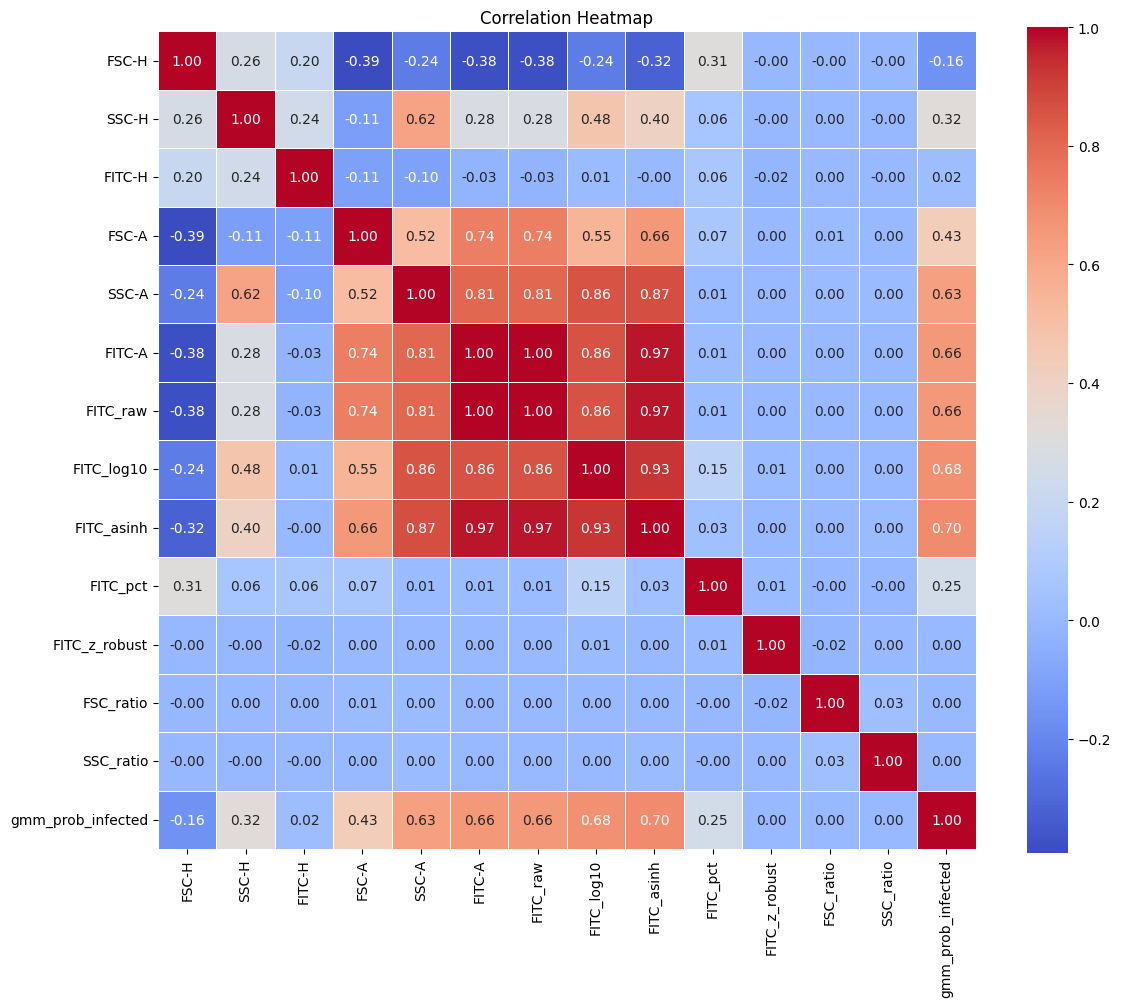

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def compute_fast_pearson(df):
    """
    Быстро считает корреляционную матрицу Pearson только по числовым колонкам.
    Возвращает DataFrame корреляций.
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr = numeric_df.corr(method='pearson')
    return corr

def plot_corr_heatmap(corr, figsize=(12, 10), cmap="coolwarm"):
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=True,       # подписывать значения
        fmt=".2f",        # формат
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar=True
    )
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

# Пример использования
corr_matrix = compute_fast_pearson(df)
# corr_matrix.to_parquet("correlation_matrix_pearson.parquet")
plot_corr_heatmap(corr_matrix)

In [10]:
# simple_lgbm_train.py
import os
import glob
import logging
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import lightgbm as lgb
import joblib

# ========== USER CONFIG ==========
PARQUET_DIR = r"E:\\parquet\\processed"   # папка с per-sample parquet
OUT_TMP = os.path.join(PARQUET_DIR, "_tmp_lgbm_simple")
os.makedirs(OUT_TMP, exist_ok=True)

TRAIN_CSV = os.path.join(OUT_TMP, "train.csv")
VAL_CSV   = os.path.join(OUT_TMP, "val.csv")

LABEL_COL = "label"
DROP_COLS = ['FITC-A']   # убираем FITC-A как просил
VAL_FRAC = 0.1           # доля файлов в валидации
RANDOM_SEED = 42

MODEL_OUT = os.path.join(PARQUET_DIR, "lgbm_simple.joblib")

# LightGBM params - простой рабочий набор
LGB_PARAMS = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.05,
    "num_leaves": 127,
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_jobs": -1
}
NUM_BOOST_ROUND = 1000
VERBOSE_EVAL = 50
# ================================

# ========== logging ==========
logger = logging.getLogger("simple_lgbm")
logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
ch = logging.StreamHandler()
ch.setFormatter(fmt)
logger.addHandler(ch)
fh = logging.FileHandler(os.path.join(OUT_TMP, "train.log"))
fh.setFormatter(fmt)
logger.addHandler(fh)
# ============================

def list_parquet_files(parquet_dir):
    files = sorted(glob.glob(os.path.join(parquet_dir, "*.parquet")))
    if len(files) == 0:
        raise FileNotFoundError("No parquet files in " + parquet_dir)
    return files

def infer_feature_columns(sample_file, label_col=LABEL_COL, drop_cols=None):
    df = pd.read_parquet(sample_file)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    feat_cols = [c for c in num_cols if c != label_col and not str(c).startswith("__")]
    if drop_cols:
        feat_cols = [c for c in feat_cols if c not in drop_cols]
    feat_cols = sorted(feat_cols)
    return feat_cols

def write_files_csv_strict(file_list, out_csv, feature_cols, label_col=LABEL_COL):
    """
    Формируем CSV с заголовком в строгом порядке feature_cols + label.
    Заголовок пишем вручную (гарантированно).
    Далее дозаписываем все строки (header=False).
    При первой записи логируем head() и dtypes.
    """
    # header line
    cols = feature_cols.copy()
    if label_col is not None:
        cols = cols + [label_col]

    # write header
    with open(out_csv, "w", encoding="utf-8") as fh:
        fh.write(",".join(cols) + "\n")

    first_chunk = True
    total_rows = 0
    for p in tqdm(file_list, desc=f"Writing {os.path.basename(out_csv)}"):
        try:
            df = pd.read_parquet(p)
        except Exception as e:
            logger.warning(f"Can't read {p}: {e}")
            continue

        # ensure columns exist
        for c in feature_cols:
            if c not in df.columns:
                df[c] = np.nan
        if label_col not in df.columns:
            df[label_col] = 0  # если нет label, ставим 0 (можно изменить)

        # convert label to 0/1
        if label_col in df.columns:
            lbl = df[label_col]
            if lbl.dtype == 'bool':
                df[label_col] = lbl.astype(int)
            else:
                df[label_col] = lbl.replace({'True':1,'TRUE':1,'true':1,'False':0,'FALSE':0,'false':0})
                df[label_col] = pd.to_numeric(df[label_col], errors='coerce').fillna(0).astype(int)

        # coerce features to numeric
        for c in feature_cols:
            df[c] = pd.to_numeric(df[c], errors='coerce')

        # replace inf and impute medians per-file
        df = df.replace([np.inf, -np.inf], np.nan)
        med = df[feature_cols + [label_col]].median()
        df = df.fillna(med)

        # reorder columns
        df_out = df[cols]

        # log head/dtypes for the very first chunk
        if first_chunk:
            logger.info(f"First chunk from file {os.path.basename(p)} for CSV {os.path.basename(out_csv)}")
            logger.info("Head:\n" + df_out.head(5).to_string())
            logger.info("Dtypes: " + str(df_out.dtypes.to_dict()))
            first_chunk = False

        # append rows without header
        df_out.to_csv(out_csv, mode="a", index=False, header=False)
        total_rows += len(df_out)

    logger.info(f"Wrote {total_rows} rows to {out_csv}")
    return out_csv

def train_from_csv(train_csv, val_csv, feature_cols):
    logger.info("Creating lgb.Dataset from CSVs")
    try:
        dtrain = lgb.Dataset(train_csv)
        dval = lgb.Dataset(val_csv, reference=dtrain)
    except Exception as e:
        # fallback: load small chunk via pandas if dataset creation fails
        logger.warning("lgb.Dataset(file) failed: " + str(e))
        train_df = pd.read_csv(train_csv)
        val_df = pd.read_csv(val_csv)
        dtrain = lgb.Dataset(train_df[feature_cols].values, label=train_df[LABEL_COL].values)
        dval = lgb.Dataset(val_df[feature_cols].values, label=val_df[LABEL_COL].values, reference=dtrain)

    logger.info("Start training LightGBM")
    try:
        booster = lgb.train(
            LGB_PARAMS,
            dtrain,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[dtrain, dval],
            valid_names=['train','valid'],
            verbose_eval=VERBOSE_EVAL
        )
    except TypeError:
        # very old/new API differences, try minimal call
        logger.warning("lgb.train verbose/valid_sets compatibility issue, trying minimal train call.")
        booster = lgb.train(LGB_PARAMS, dtrain, num_boost_round=NUM_BOOST_ROUND)
    logger.info("Training finished")
    return booster

def main():
    files = list_parquet_files(PARQUET_DIR)
    logger.info(f"Found {len(files)} parquet files (samples).")

    feat_cols = infer_feature_columns(files[0], label_col=LABEL_COL, drop_cols=DROP_COLS)
    logger.info("Feature columns to use: %s", feat_cols)

    # split files into train/val (by files)
    random.seed(RANDOM_SEED)
    files_shuffled = files.copy()
    random.shuffle(files_shuffled)
    n_val = max(1, int(len(files_shuffled) * VAL_FRAC))
    val_files = files_shuffled[:n_val]
    train_files = files_shuffled[n_val:]

    logger.info(f"Train files: {len(train_files)}, Val files: {len(val_files)}")

    # write CSVs with headers (strict)
    if os.path.exists(TRAIN_CSV):
        os.remove(TRAIN_CSV)
    if os.path.exists(VAL_CSV):
        os.remove(VAL_CSV)

    write_files_csv_strict(train_files, TRAIN_CSV, feat_cols, label_col=LABEL_COL)
    write_files_csv_strict(val_files, VAL_CSV, feat_cols, label_col=LABEL_COL)

    # quick sanity: check label distribution in train/val
    try:
        tr = pd.read_csv(TRAIN_CSV, usecols=[LABEL_COL])
        va = pd.read_csv(VAL_CSV, usecols=[LABEL_COL])
        logger.info("Train label stats: total=%d, positives=%d, rate=%.6f", len(tr), int(tr[LABEL_COL].sum()), tr[LABEL_COL].mean())
        logger.info("Val   label stats: total=%d, positives=%d, rate=%.6f", len(va), int(va[LABEL_COL].sum()), va[LABEL_COL].mean())
    except Exception as e:
        logger.warning("Couldn't read small CSV for label stats: " + str(e))

    # train
    booster = train_from_csv(TRAIN_CSV, VAL_CSV, feat_cols)

    # save model + feature list
    joblib.dump({'booster': booster, 'features': feat_cols}, MODEL_OUT)
    logger.info("Saved model to %s", MODEL_OUT)

if __name__ == "__main__":
    main()

2025-12-02 09:31:25,335 INFO Found 1435 parquet files (samples).
2025-12-02 09:31:25,339 INFO Feature columns to use: ['FITC-H', 'FITC_asinh', 'FITC_log10', 'FITC_pct', 'FITC_raw', 'FITC_z_robust', 'FSC-A', 'FSC-H', 'FSC_ratio', 'SSC-A', 'SSC-H', 'SSC_ratio', 'gmm_prob_infected']
2025-12-02 09:31:25,340 INFO Train files: 1292, Val files: 143
Writing train.csv:   0%|          | 0/1292 [00:00<?, ?it/s]2025-12-02 09:31:25,383 INFO First chunk from file KP.3.1.1_57-Fc_H11_c3e6fab1-ce99-11f0-9a46-f02f74d321c5_processed.parquet for CSV train.csv
2025-12-02 09:31:25,385 INFO Head:
   FITC-H  FITC_asinh  FITC_log10  FITC_pct  FITC_raw  FITC_z_robust     FSC-A     FSC-H  FSC_ratio     SSC-A     SSC-H     SSC_ratio  gmm_prob_infected  label
0     NaN    0.037710   -2.423330  0.781725  0.003772       2.104407  0.013431  0.003956   3.395439  0.323672  0.999230  3.239218e-01           0.800049      0
1     NaN    0.076624   -2.115155  0.889200  0.007670       4.187911  1.000000  0.971545   1.029289

KeyboardInterrupt: 

In [11]:
d = pd.read_parquet("E:\\parquet\\merged_processed.parquet")
d.head()

,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected
0.0,0.052952,0.623713,0.086024,0.008641,0.515030,0.009820,False,0.009820,-2.007822,0.098048,0.627628,0.595366,0.163190,0.825748,0.996436
1.0,0.688091,1.000000,0.099226,0.573388,0.989684,0.010410,False,0.010410,-1.982525,0.103909,0.888889,5.193378,0.833302,0.989684,0.914950
2.0,0.471071,0.837872,0.105617,0.295011,0.784652,0.010085,False,0.010085,-1.996261,0.100684,0.813814,2.696776,0.626257,0.936482,0.992468
3.0,0.017603,0.532765,0.078204,0.001257,0.504533,0.009689,False,0.009689,-2.013658,0.096743,0.354354,-0.465317,0.071402,0.947008,0.996098
4.0,0.045924,0.438589,0.089136,0.004386,0.486525,0.009801,False,0.009801,-2.008667,0.097858,0.600601,0.441879,0.095504,1.109296,0.996459


In [13]:
d

,FSC-H,SSC-H,FITC-H,FSC-A,SSC-A,FITC-A,label,FITC_raw,FITC_log10,FITC_asinh,FITC_pct,FITC_z_robust,FSC_ratio,SSC_ratio,gmm_prob_infected
0.0,0.052952,0.623713,0.086024,0.008641,0.515030,0.009820,False,0.009820,-2.007822,0.098048,0.627628,0.595366,0.163190,0.825748,0.996436
1.0,0.688091,1.000000,0.099226,0.573388,0.989684,0.010410,False,0.010410,-1.982525,0.103909,0.888889,5.193378,0.833302,0.989684,0.914950
2.0,0.471071,0.837872,0.105617,0.295011,0.784652,0.010085,False,0.010085,-1.996261,0.100684,0.813814,2.696776,0.626257,0.936482,0.992468
3.0,0.017603,0.532765,0.078204,0.001257,0.504533,0.009689,False,0.009689,-2.013658,0.096743,0.354354,-0.465317,0.071402,0.947008,0.996098
4.0,0.045924,0.438589,0.089136,0.004386,0.486525,0.009801,False,0.009801,-2.008667,0.097858,0.600601,0.441879,0.095504,1.109296,0.996459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.224035,0.016337,NaN,0.094823,0.025527,0.003873,False,0.003873,-2.411867,0.038718,0.458120,-0.141791,0.423250,1.562520,0.098564
NaN,0.313604,0.016386,NaN,0.142364,0.025911,0.038430,True,0.038430,-1.415313,0.375424,0.957305,5.660955,0.453963,1.581304,0.999998
NaN,0.200443,0.013140,NaN,0.087041,0.025016,0.003121,False,0.003121,-2.505568,0.031205,0.299639,-0.687391,0.434243,1.903751,0.096606
NaN,0.219027,0.013388,NaN,0.092225,0.025100,0.003521,False,0.003521,-2.453224,0.035202,0.386808,-0.382602,0.421064,1.874776,0.095070


In [4]:
# evaluate_and_infer.py
import os
import glob
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, f1_score,
    mean_absolute_error, r2_score
)

# ========== USER ==========
PARQUET_DIR = r"E:\\parquet\\processed"   # <- папка с per-sample parquet
MODEL_PATH = r"E:\\parquet\\lgbm_cell_full.joblib"
LABEL_COL = "label"                     # имя столбца с cell-level меткой (bool/int) если есть
OUT_SUMMARY = r"E:\\parquet\\inference_summary.xlsx"
SAMPLE_AGG_CSV = r"E:\\parquet\\sample_level_preds.parquet"
# =========================

# -------- load model ----------
m = joblib.load(MODEL_PATH)
# handle possible shapes of saved object
if isinstance(m, dict) and 'booster' in m:
    model_type = 'lgb_booster'
    booster = m['booster']
    feature_cols = m['features']
elif isinstance(m, dict) and 'model' in m:
    model_type = 'sklearn'
    booster = m['model']
    feature_cols = m.get('features', None)
else:
    # assume sklearn-like object directly
    model_type = 'sklearn'
    booster = m
    feature_cols = m.feature_name_ if hasattr(m, 'feature_name_') else None

print("Model type detected:", model_type)
if feature_cols is None:
    raise RuntimeError("Feature columns list not found in saved model. Please provide 'features'.")

# helper to predict probs from loaded model
def predict_probs_on_df(X_df):
    """
    X_df: pandas DataFrame with columns = feature_cols
    returns numpy array of probabilities (shape (n,))
    """
    X = X_df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0).values
    if model_type == 'lgb_booster':
        # booster expects numpy 2d
        # if booster was trained with dataset having certain number of features, ensure shapes match
        try:
            probs = booster.predict(X, num_iteration=getattr(booster, 'best_iteration', None))
        except TypeError:
            probs = booster.predict(X)
        # booster.predict gives probability for positive class
        return probs
    else:
        # sklearn-like
        if hasattr(booster, "predict_proba"):
            return booster.predict_proba(X)[:, 1]
        else:
            # fallback: predict (classes) -> treat as 0/1
            preds = booster.predict(X)
            return preds.astype(float)

# -------- inference over folder ----------
files = sorted(glob.glob(os.path.join(PARQUET_DIR, "*.parquet")))
if len(files) == 0:
    raise SystemExit("No parquet files found in " + PARQUET_DIR)

out_rows = []
# we'll also accumulate some sample-level objects for metrics
all_cell_probs = []
all_cell_labels = []

print("Running inference over files:", len(files))
for p in tqdm(files, desc="Files"):
    try:
        df = pd.read_parquet(p)
    except Exception as e:
        print("Can't read", p, e)
        continue
    # ensure feature cols present; add missing as NaN
    for c in feature_cols:
        if c not in df.columns:
            df[c] = np.nan

    Xdf = df[feature_cols]
    probs = predict_probs_on_df(Xdf)
    mean_prob = float(np.nanmean(probs))  # mean prob per cell (0..1)
    pred_pct = 100.0 * mean_prob

    # sample-level true % if label exists
    if LABEL_COL in df.columns:
        true_pct = 100.0 * float(df[LABEL_COL].astype(bool).mean())
    else:
        true_pct = np.nan

    # collect cell-level metrics
    n_cells = len(df)
    n_pos = int(df[LABEL_COL].astype(bool).sum()) if LABEL_COL in df.columns else None

    out_rows.append({
        'sample_file': os.path.basename(p),
        'n_cells': n_cells,
        'pred_pct_infected': pred_pct,
        'true_pct_infected': true_pct,
        'n_pos': n_pos
    })

    # optionally keep cell-level probs/labels for global metrics (may be large)
    if LABEL_COL in df.columns:
        all_cell_probs.append(probs)
        all_cell_labels.append(df[LABEL_COL].astype(int).values)

# make summary df
summary_df = pd.DataFrame(out_rows).sort_values('sample_file').reset_index(drop=True)
summary_df.to_parquet(SAMPLE_AGG_CSV, index=False)
summary_df.to_excel(OUT_SUMMARY, index=False)
print("Saved sample-level predictions to:", SAMPLE_AGG_CSV)
print("Saved summary xlsx to:", OUT_SUMMARY)

# -------- compute metrics --------
# Sample-level regression-like metrics (predicted % vs true %)
mask = summary_df['true_pct_infected'].notna()
if mask.sum() > 0:
    mae = mean_absolute_error(summary_df.loc[mask,'true_pct_infected'], summary_df.loc[mask,'pred_pct_infected'])
    r2 = r2_score(summary_df.loc[mask,'true_pct_infected'], summary_df.loc[mask,'pred_pct_infected'])
    print("Sample-level MAE:", mae)
    print("Sample-level R2:", r2)
else:
    print("No sample-level true % available to compute MAE/R2.")

# Cell-level metrics (global over concatenated cells) — careful with memory
if len(all_cell_probs) > 0:
    probs_all = np.concatenate(all_cell_probs)
    labels_all = np.concatenate(all_cell_labels)
    print("Cell-level: total cells with labels:", len(labels_all))
    try:
        roc = roc_auc_score(labels_all, probs_all)
        pr = average_precision_score(labels_all, probs_all)
        print("Cell-level ROC AUC:", roc)
        print("Cell-level PR AUC (avg precision):", pr)
    except Exception as e:
        print("Could not compute cell-level ROC/PR:", e)

# -------- choose threshold by maximizing F1 on a sample (if labels exist) --------
if len(all_cell_probs) > 0:
    # to be fast, sample (e.g., up to 1e6 cells)
    MAX_SAMPLE = 2000000
    n_total = len(labels_all)
    if n_total > MAX_SAMPLE:
        rng = np.random.RandomState(42)
        idx = rng.choice(n_total, size=MAX_SAMPLE, replace=False)
        y_sample = labels_all[idx]
        p_sample = probs_all[idx]
    else:
        y_sample = labels_all
        p_sample = probs_all

    thresholds = np.linspace(0.0, 1.0, 101)
    best_f1 = -1.0
    best_t = 0.5
    for t in thresholds:
        f1 = f1_score(y_sample, (p_sample >= t).astype(int))
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    print(f"Best threshold on sampled cell data by F1: {best_t:.3f}, F1={best_f1:.4f}")
else:
    best_t = 0.5
    print("No cell labels: default threshold = 0.5")

# -------- feature importance --------
# try to extract feature importances
feat_imp = None
if model_type == 'lgb_booster':
    try:
        names = booster.feature_name()
        gains = booster.feature_importance(importance_type='gain')
        feat_imp = pd.DataFrame({'feature': names, 'gain': gains}).sort_values('gain', ascending=False)
    except Exception:
        try:
            names = booster.feature_name()
            imp = booster.feature_importance()
            feat_imp = pd.DataFrame({'feature': names, 'importance': imp}).sort_values('importance', ascending=False)
        except Exception:
            feat_imp = None
else:
    try:
        imp = booster.feature_importances_
        feat_imp = pd.DataFrame({'feature': feature_cols, 'importance': imp}).sort_values('importance', ascending=False)
    except Exception:
        feat_imp = None

if feat_imp is not None:
    print("Top features by importance:")
    print(feat_imp.head(20))
    feat_imp.to_csv(os.path.join(os.path.dirname(MODEL_PATH), "feature_importances.csv"), index=False)
    print("Feature importances saved.")
else:
    print("Could not get feature importances for model type:", model_type)

print("Done.")


Model type detected: lgb_booster
Running inference over files: 1435


Files: 100%|██████████| 1435/1435 [01:54<00:00, 12.54it/s]


Saved sample-level predictions to: E:\\parquet\\sample_level_preds.parquet
Saved summary xlsx to: E:\\parquet\\inference_summary.xlsx
Sample-level MAE: 92.88420346975134
Sample-level R2: -224.87029457933906
Cell-level: total cells with labels: 48463283
Cell-level ROC AUC: 0.5000002892538501
Cell-level PR AUC (avg precision): 0.0726336036391446
Best threshold on sampled cell data by F1: 0.000, F1=0.1358
Top features by importance:
      feature          gain
8    Column_8  1.075157e+14
10  Column_10  1.190323e+13
6    Column_6  6.190502e+12
2    Column_2  5.667913e+12
1    Column_1  5.074500e+12
0    Column_0  4.544785e+12
9    Column_9  3.635632e+12
11  Column_11  3.171653e+12
7    Column_7  2.686919e+12
3    Column_3  1.001515e+12
12  Column_12  1.562027e+11
4    Column_4  1.435918e+11
5    Column_5  1.154161e+11
13  Column_13  1.864853e+09
Feature importances saved.
Done.
